In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import jdc
import os
from tqdm import tqdm
from scipy import stats

from rl_glue import RLGlue
from agent.model_free_agent import QLearningAgent, ExpectedSarsaAgent
from agent.dynaq_agent import DynaQAgent, DynaQPlusAgent
from environment.fogg_behavioural_model import Patient 

In [2]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [10,5]})

In [3]:
time_of_the_day = 4 # morning, midday, evening, night
day_of_the_week = 2 # week day, weekend
activity_score = 2# low/ high
location = 2 # home/ other
sleeping = 2 # yes/no
valence = 2 # positive/negative
arousal = 2 # low/high
motion = 2 #stationary, walking
cognitive_load = 2 # low/ high


In [4]:
num_states = cognitive_load * motion  * arousal * valence * sleeping * location * activity_score * day_of_the_week * time_of_the_day

In [5]:
num_states

1024

In [6]:

agent_info = {"num_actions": 4, "num_states": 1024, "epsilon": 0.1, "step_size": 0.5, "discount": 1.0, "planning_steps": 5}
env_info = {'behaviour_threshold': 20, 'has_family':True}
num_runs = 200 # The number of runs
num_episodes = 100 # The number of episodes in each run

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:43<00:00,  4.62it/s]


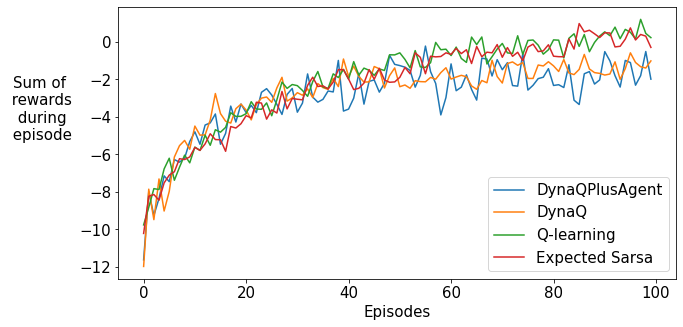

In [7]:
agents = {
    "DynaQPlusAgent": DynaQPlusAgent,
    "DynaQ": DynaQAgent,
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes

for algorithm in [ "DynaQPlusAgent", "DynaQ", "Q-learning", "Expected Sarsa"]:
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    for run in tqdm(range(num_runs)):
        agent_info["seed"] = run
        rl_glue = RLGlue(Patient, agents[algorithm])
        rl_glue.rl_init(agent_info, env_info)

        reward_sums = []
        state_visits = np.zeros(1024)
        last_episode_total_reward = 0
        for episode in range(num_episodes):
            if episode < num_episodes - 10:
                # Runs an episode
                rl_glue.rl_episode(10000) 
            else: 
                # Runs an episode while keeping track of visited states
                state, action = rl_glue.rl_start()
                state_visits[state] += 1
                is_terminal = False
                while not is_terminal:
                    reward, state, action, is_terminal = rl_glue.rl_step()
                    state_visits[state] += 1

            reward_sums.append(rl_glue.rl_return() - last_episode_total_reward)
            last_episode_total_reward = rl_glue.rl_return()
        all_reward_sums[algorithm].append(reward_sums)
        all_state_visits[algorithm].append(state_visits)

for algorithm in [ "DynaQPlusAgent","DynaQ", "Q-learning", "Expected Sarsa"]:
    plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)

plt.legend()
plt.show()

In [8]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize': [10,10]})

<ipython-input-9-abe471d4b0f2>:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cm.set_bad('gray')
<ipython-input-9-abe471d4b0f2>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cax = plt.axes([0.85, 0.0, 0.075, 1.])


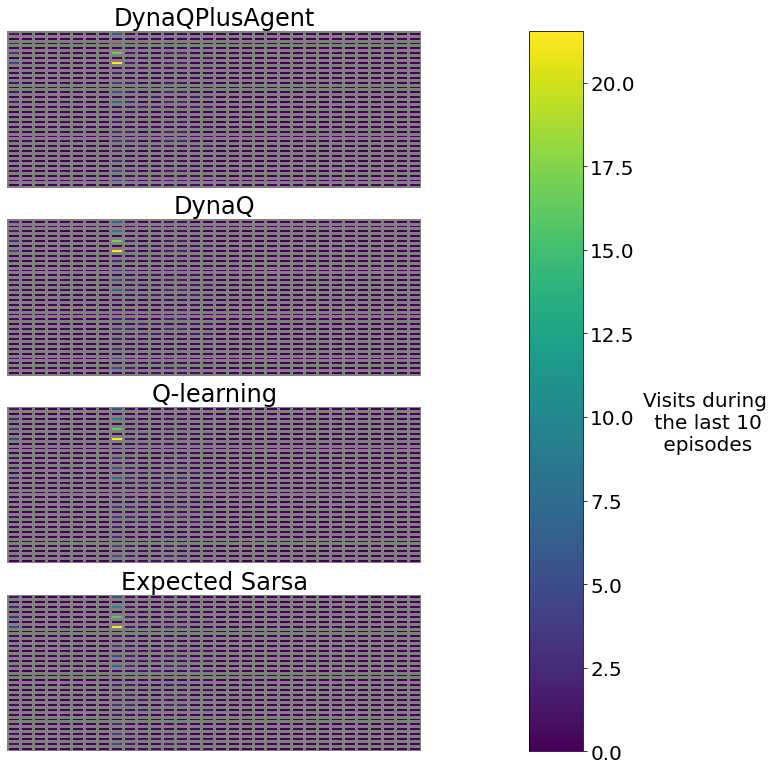

In [9]:
for algorithm, position in [("DynaQPlusAgent", 411),("DynaQ", 412), ("Q-learning", 413), ("Expected Sarsa", 414)]:
    plt.subplot(position)
    average_state_visits = np.array(all_state_visits[algorithm]).mean(axis=0)
    grid_state_visits = average_state_visits.reshape((32,32))
    plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=2)
    plt.title(algorithm)
    plt.axis('off')
    cm = plt.get_cmap()
    cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([0.85, 0.0, 0.075, 1.])
    
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel("Visits during\n the last 10\n episodes", rotation=0, labelpad=70)
plt.show()

In [12]:
from itertools import product

agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
env = Patient
all_reward_sums = {}
step_sizes = np.linspace(0.1,1.0,10)
agent_info = {"num_actions": 4, "num_states": 1024, "epsilon": 0.1, "discount": 1.0}
env_info = {'behaviour_threshold': 20, 'has_family':True}
num_runs = 30
num_episodes = 100
all_reward_sums = {}

algorithms = ["Q-learning", "Expected Sarsa"]
cross_product = list(product(algorithms, step_sizes, range(num_runs)))
for algorithm, step_size, run in tqdm(cross_product):
    if (algorithm, step_size) not in all_reward_sums:
        all_reward_sums[(algorithm, step_size)] = []

    agent_info["step_size"] = step_size
    agent_info["seed"] = run
    rl_glue = RLGlue(env, agents[algorithm])
    rl_glue.rl_init(agent_info, env_info)

    last_episode_total_reward = 0
    for episode in range(num_episodes):
        rl_glue.rl_episode(0)
    all_reward_sums[(algorithm, step_size)].append(rl_glue.rl_return()/num_episodes)
        

for algorithm in ["Q-learning", "Expected Sarsa"]:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([stats.sem(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [01:56<00:00,  5.16it/s]


NameError: name 'sem' is not defined